In [ ]:
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_DIR = Path("/kaggle/input/imagesoasis/Data")
KEEP_CLASSES = ["Non Demented", "Very mild Dementia", "Mild Dementia"]
DOWN_TARGET = 10000   


In [ ]:

items = []

for cls in KEEP_CLASSES + ["Moderate Dementia"]:
    folder = DATA_DIR / cls
    files = sorted([f for ext in ("*.jpg", "*.png", "*.jpeg") for f in folder.glob(ext)])

    for f in files:
        items.append((str(f), cls))

df = pd.DataFrame(items, columns=["path", "label_name"])
print("Loaded images:", len(df))



Loaded images: 86437


In [ ]:

df = df[df["label_name"].isin(KEEP_CLASSES)].reset_index(drop=True)
print("\nRemaining (3 classes only):")
print(df["label_name"].value_counts())




Remaining (3 classes only):
label_name
Non Demented          67222
Very mild Dementia    13725
Mild Dementia          5002
Name: count, dtype: int64


In [ ]:

balanced = []

for cls in KEEP_CLASSES:
    cls_df = df[df["label_name"] == cls]

    if cls in ["Non Demented", "Very mild Dementia"] and len(cls_df) > DOWN_TARGET:
        cls_df = cls_df.sample(DOWN_TARGET, random_state=42)

    balanced.append(cls_df)

balanced_df = pd.concat(balanced).reset_index(drop=True)

print("\nAfter balancing:")
print(balanced_df["label_name"].value_counts())



After balancing:
label_name
Non Demented          10000
Very mild Dementia    10000
Mild Dementia          5002
Name: count, dtype: int64


In [ ]:

train_list = []
val_list = []
test_list = []

for cls in KEEP_CLASSES:
    cls_df = balanced_df[balanced_df["label_name"] == cls]

    train_tmp, temp = train_test_split(
        cls_df, test_size=0.20, shuffle=True, random_state=42
    )
    val_tmp, test_tmp = train_test_split(
        temp, test_size=0.50, shuffle=True, random_state=42
    )

    train_list.append(train_tmp)
    val_list.append(val_tmp)
    test_list.append(test_tmp)

train_df3 = pd.concat(train_list).reset_index(drop=True)
val_df3   = pd.concat(val_list).reset_index(drop=True)
test_df3  = pd.concat(test_list).reset_index(drop=True)



In [ ]:

train_df3.to_csv("train_df3.csv", index=False)
val_df3.to_csv("val_df3.csv", index=False)
test_df3.to_csv("test_df3.csv", index=False)

print("\nSaved:")
print("train_df3.csv:", len(train_df3))
print("val_df3.csv:", len(val_df3))
print("test_df3.csv:", len(test_df3))




Saved:
train_df3.csv: 20001
val_df3.csv: 2500
test_df3.csv: 2501


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd


IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 40
LR = 1e-4
AUTOTUNE = tf.data.AUTOTUNE
KEEP_CLASSES = ["Non Demented", "Very mild Dementia", "Mild Dementia"]


2025-11-26 15:01:19.156064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764169279.338069      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764169279.394810      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:

train_df3 = pd.read_csv("train_df3.csv")
val_df3   = pd.read_csv("val_df3.csv")
test_df3  = pd.read_csv("test_df3.csv")


label_to_idx = {name: i for i, name in enumerate(KEEP_CLASSES)}
train_df3["label_idx2"] = train_df3["label_name"].map(label_to_idx)
val_df3["label_idx2"]   = val_df3["label_name"].map(label_to_idx)
test_df3["label_idx2"]  = test_df3["label_name"].map(label_to_idx)



In [ ]:

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    img = resnet_preprocess(img)
    return img, label

def augment(image, label):
    image = tf.image.random_brightness(image, 0.02)
    image = tf.image.random_contrast(image, 0.98, 1.02)
    noise = tf.random.normal(tf.shape(image), stddev=2.0)
    image = tf.clip_by_value(image + noise, -128.0, 128.0)
    return image, label

def df_to_ds(df, shuffle=False, aug=False):
    ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["label_idx2"].values))

    if shuffle:
        ds = ds.shuffle(10000)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if aug:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = df_to_ds(train_df3, shuffle=True, aug=True)
val_ds   = df_to_ds(val_df3)
test_ds  = df_to_ds(test_df3)




I0000 00:00:1764169293.313885      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:

y = train_df3["label_idx2"].values
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weights = {i: float(w) for i, w in enumerate(weights)}



In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess



inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


base = DenseNet121(
    weights="imagenet",
    include_top=False,     
    input_tensor=inputs
)

base.trainable = False  


x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = models.Model(inputs, outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,675 (27.85 MB)

 Trainable params: 263,171 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:

class F1ScoreCallback(callbacks.Callback):
    def __init__(self, val_ds):
        super().__init__()
        self.val_ds = val_ds
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

 
        for x, y in self.val_ds:
            preds = self.model.predict(x, verbose=0)
            preds = np.argmax(preds, axis=1)
            y_true.extend(y.numpy())
            y_pred.extend(preds)


        from sklearn.metrics import f1_score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"— Epoch {epoch+1} F1 Score: {f1:.4f}")


        if f1 > self.best_f1:
            self.best_f1 = f1
            print("Saving best model (F1 improved).")
            self.model.save("best_densenet_f1.keras")




In [ ]:

checkpoint = callbacks.ModelCheckpoint(
    "best_densenet_val.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

f1_callback = F1ScoreCallback(val_ds)




In [ ]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduce, f1_callback]
)



Epoch 1/15


I0000 00:00:1764169309.128280     107 service.cc:148] XLA service 0x7c5a8c0033c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764169309.129055     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764169311.883772     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1251 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.6706 - loss: 4.0694 

I0000 00:00:1764169321.458565     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5691 - loss: 1.4258
Epoch 1: val_loss improved from inf to 1.28956, saving model to best_densenet_val.keras
— Epoch 1 F1 Score: 0.3159
Saving best model (F1 improved).
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 161s 110ms/step - accuracy: 0.5691 - loss: 1.4255 - val_accuracy: 0.3544 - val_loss: 1.2896 - learning_rate: 1.0000e-04
Epoch 2/15
1249/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6829 - loss: 0.5917
Epoch 2: val_loss improved from 1.28956 to 1.22848, saving model to best_densenet_val.keras
— Epoch 2 F1 Score: 0.4086
Saving best model (F1 improved).
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.6828 - loss: 0.5920 - val_accuracy: 0.4192 - val_loss: 1.2285 - learning_rate: 1.0000e-04
Epoch 3/15
1249/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7118 - loss: 0.5530
Epoch 3: val_loss improved from 1.22848 to 0.89936, saving model to best_densenet_val.keras
— Epoch 3 F1 Score: 0.5791
Saving best model (F1 imp

In [ ]:


checkpoint = callbacks.ModelCheckpoint(
    "best_densenet_val.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


f1_callback = F1ScoreCallback(val_ds)



In [ ]:


base.trainable = True  

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:


history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduce, f1_callback]
)




Epoch 1/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7287 - loss: 0.5644
Epoch 1: val_loss improved from inf to 0.68085, saving model to best_densenet_val.keras
— Epoch 1 F1 Score: 0.7243
Saving best model (F1 improved).
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 373s 194ms/step - accuracy: 0.7287 - loss: 0.5644 - val_accuracy: 0.7144 - val_loss: 0.6808 - learning_rate: 1.0000e-05
Epoch 2/10
1250/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8265 - loss: 0.3762
Epoch 2: val_loss did not improve from 0.68085
— Epoch 2 F1 Score: 0.6690
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - accuracy: 0.8266 - loss: 0.3760 - val_accuracy: 0.6532 - val_loss: 0.9758 - learning_rate: 1.0000e-05
Epoch 3/10
1250/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9011 - loss: 0.2287
Epoch 3: val_loss improved from 0.68085 to 0.43219, saving model to best_densenet_val.keras
— Epoch 3 F1 Score: 0.8460
Saving best model (F1 improved).
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accur

In [ ]:

loss, acc = model.evaluate(test_ds)
print("Test Accuracy:", acc)




157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9722 - loss: 0.0808
Test Accuracy: 0.9740104079246521


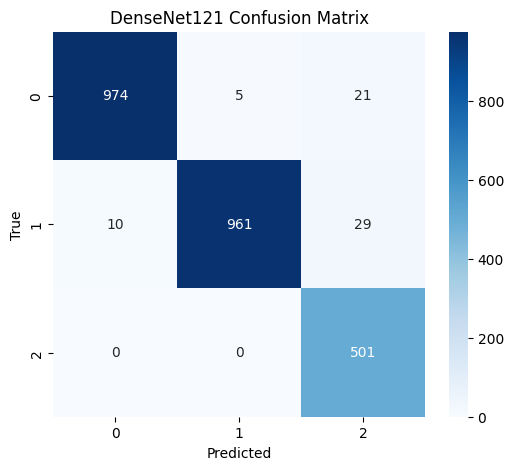

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for x, y in test_ds:
    preds = model.predict(x, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DenseNet121 Confusion Matrix")
plt.show()




In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for x, y in test_ds:
    preds = model.predict(x, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(y.numpy())

print(classification_report(
    y_true,
    y_pred,
    target_names=KEEP_CLASSES
))




                    precision    recall  f1-score   support

      Non Demented       0.99      0.97      0.98      1000
Very mild Dementia       0.99      0.96      0.98      1000
     Mild Dementia       0.91      1.00      0.95       501

          accuracy                           0.97      2501
         macro avg       0.96      0.98      0.97      2501
      weighted avg       0.98      0.97      0.97      2501



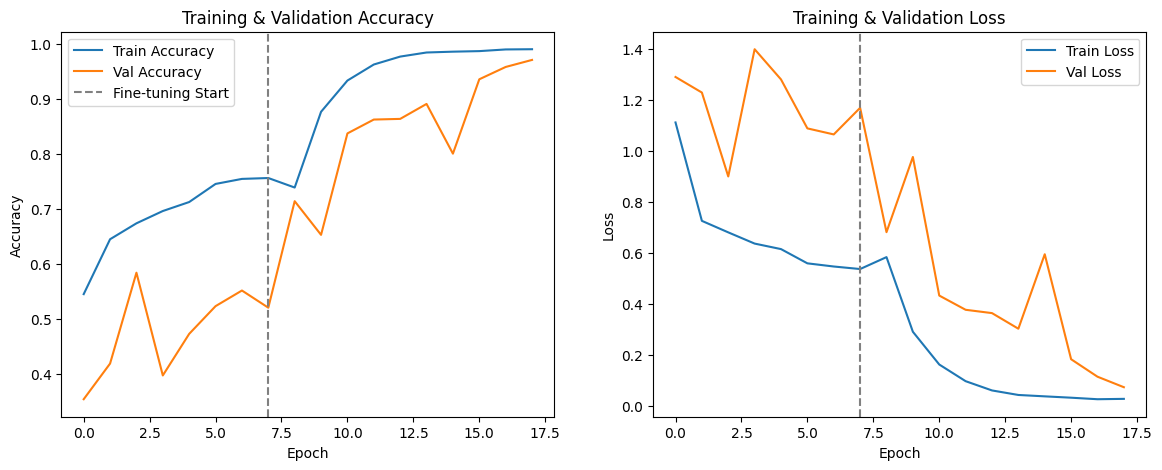

In [ ]:

import matplotlib.pyplot as plt

acc1 = history.history["accuracy"]
val_acc1 = history.history["val_accuracy"]
loss1 = history.history["loss"]
val_loss1 = history.history["val_loss"]

acc2 = history_ft.history["accuracy"]
val_acc2 = history_ft.history["val_accuracy"]
loss2 = history_ft.history["loss"]
val_loss2 = history_ft.history["val_loss"]

plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(acc1 + acc2, label="Train Accuracy")
plt.plot(val_acc1 + val_acc2, label="Val Accuracy")
plt.axvline(len(acc1)-1, color='gray', linestyle='--', label="Fine-tuning Start")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss1 + loss2, label="Train Loss")
plt.plot(val_loss1 + val_loss2, label="Val Loss")
plt.axvline(len(loss1)-1, color='gray', linestyle='--')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
